# This is for waltzdb

In [19]:
import mlflow
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from mlflow.entities import ViewType
import pandas as pd
import pprint
import json
import ast
import sys
sys.path.insert(0, '/novo/projects/departments/cdd/public/users/ehec/au24/ML-BP-Domino')

from omegaconf import OmegaConf
import seaborn as sns
import lacroix
from pathlib import Path
from hydra import compose, initialize, initialize_config_dir
from src.helpers.dataset import CSVDataLoader
from src.model.composite_model import CompositeModel
from torch.nn.utils.rnn import pad_sequence
import torch
from sklearn.metrics import matthews_corrcoef
from src.helpers.pytorch.light_attention import LightAttentionModule
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import os

In [108]:
serrano = pd.read_csv('/novo/projects/departments/cdd/public/users/ehec/sbxw_files_2/fibrillatioNN_prediction/sbxw/tables/serrano_filteredlysozyme_filteredwaltzoverlap_filteredlt6.csv')
waltz = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv')
waltz_plain = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb.csv')
amypro = pd.read_csv('/novo/projects/departments/cdd/public/users/ehec/au24/datasets/amypro22.csv')
waltz = waltz[waltz['fold'] != -1]
waltz_padded = waltz.replace('train', 'test')
serrano['data_split_fold1'] = 'test'
serrano['data_split_fold2'] = 'test'
serrano['data_split_fold3'] = 'test'
serrano['data_split_fold4'] = 'test'
serrano['data_split_fold5'] = 'test'
waltz_plain['data_split_fold1'] = 'test'
waltz_plain['data_split_fold2'] = 'test'
waltz_plain['data_split_fold3'] = 'test'
waltz_plain['data_split_fold4'] = 'test'
waltz_plain['data_split_fold5'] = 'test'
amypro['data_split_fold1'] = 'test'
amypro['data_split_fold2'] = 'test'
amypro['data_split_fold3'] = 'test'
amypro['data_split_fold4'] = 'test'
amypro['data_split_fold5'] = 'test'
serrano.head(3)

/tmp/ipykernel_23771/945442870.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  waltz_padded = waltz.replace('train', 'test')


,Unnamed: 0,sequence,value_bool,parent_protein,name,group,fold,seq_aa_length,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5
0,1,PGGGKVYKPV,0,t-Protein,K19d,serrano_1,-1,10,test,test,test,test,test
1,2,PGGGKNAEVYKPV,0,t-Protein,Mut1,serrano_1,-1,13,test,test,test,test,test
2,4,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIVY,0,t-Protein,K19Chym,serrano_1,-1,36,test,test,test,test,test


In [109]:
#folders = ['plain_waltz_pad_best_model_1', 'plain_waltz_pad_best_model_2', 
#           'plain_waltz_pad_best_model_3', 'plain_waltz_pad_best_model_4', 'plain_waltz_pad_best_model_5']
folders = ['plain_waltz_pad_best_model_1']

In [193]:
ldf = {}
ldf_serr = {}
ldf_wp = {}
ldf_ap = {}
for idx, folder in enumerate(folders):
    amypro_tmp = amypro[amypro[f'data_split_fold{idx+1}'] == 'test']
    serrano_tmp = serrano[serrano[f'data_split_fold{idx+1}'] == 'test']
    waltz_plain_tmp = waltz_plain[waltz_plain[f'data_split_fold{idx+1}'] == 'test']
    waltz_tmp = waltz_padded[waltz_padded[f'data_split_fold{idx+1}'] == 'test']
    labels = np.concatenate([len(row['sequence']) * [row['value_bool']] for index, row in waltz_tmp.iterrows()]).tolist()
    pad_mask = [x for xs in list(waltz_tmp['mask']) for x in xs]
    config_path = f'/novo/projects/departments/cdd/public/users/ehec/au24/250317_models/{folder}'
    
    with initialize_config_dir(config_dir=config_path, version_base=None, job_name="test"):
        cfg = compose(config_name="esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10",
                      overrides=[f"+general.composite_model_path={config_path}"])
        print(OmegaConf.to_yaml(cfg))
        model = CompositeModel(cfg)

    dataloader = CSVDataLoader(cfg, waltz_tmp)
    predictions = model.forward(dataloader)
    ldf[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_serr = CSVDataLoader(cfg, serrano_tmp)
    predictions_serr = model.forward(dataloader_serr)
    ldf_serr[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_wp = CSVDataLoader(cfg, waltz_plain_tmp)
    predictions_wp = model.forward(dataloader_wp)
    ldf_wp[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_ap = CSVDataLoader(cfg, amypro_tmp)
    predictions_ap = model.forward(dataloader_ap)
    ldf_ap[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]
    
ldf = pd.DataFrame(ldf).sample(n=150) # 600
ldf_serr = pd.DataFrame(ldf_serr)
ldf_wp = pd.DataFrame(ldf_wp).sample(n=150) # 300
ldf_ap = pd.DataFrame(ldf_ap)

INFO:src.model.dimred:Load class (NoReduction): NoReduction
INFO:src.model.abstract_components:Load class (DimRed Model): NoReduction
INFO:src.model.predictors:Load class (LightAttention): LightAttention
INFO:src.model.abstract_components:Load class (TorchPredictorModel): LightAttention
INFO:src.model.abstract_components:Load class (Predictor Model): LightAttention
INFO:src.model.predictors:Loading model from /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_1/model.pt


general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_1
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold1
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false
  scalar

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
/novo/projects/departments/cdd/public/users/ehec/au24/ML-BP-Domino/src/helpers/dataset.py:609: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [194]:
#ldf['predictions_average'] = ldf[['predictions_1', 'predictions_2', 'predictions_3', 'predictions_4', 'predictions_5']].mean(axis=1)
#ldf['Aggregation label'] = ldf['res_value_bool'].astype(bool)

In [195]:
ldf_wp

,embeddings_1
1260,"[0.17753594, -0.2475543, 0.2842848, 0.11396984..."
932,"[0.15603323, -0.0120308995, 0.20101361, 0.1503..."
517,"[0.13963103, -0.23809366, 0.32620662, 0.256209..."
974,"[0.12350946, -0.13651656, 0.31275293, 0.202236..."
520,"[0.09918919, -0.054809038, 0.23101835, 0.16074..."
...,...
710,"[0.026970157, -0.21475099, 0.25706324, 0.07177..."
524,"[0.16626072, 0.019262483, 0.21171665, 0.001532..."
397,"[0.14296754, -0.10130733, 0.3603882, 0.1710508..."
290,"[0.16829152, -0.17468067, 0.2643797, 0.1861165..."


In [200]:
tsne = TSNE(n_components=2,perplexity=60,init='pca',random_state=42)
X_new = tsne.fit_transform(np.array(list(ldf['embeddings_1']))) # pass in the [N,H] embedding vector
X_new_serr = tsne.fit_transform(np.array(list(ldf_serr['embeddings_1']))) # pass in the [N,H] embedding vector
X_new_wp = tsne.fit_transform(np.array(list(ldf_wp['embeddings_1']))) # pass in the [N,H] embedding vector
#X_new_ap = tsne.fit_transform(np.array(list(ldf_ap['embeddings_1']))) # pass in the [N,H] embedding vector

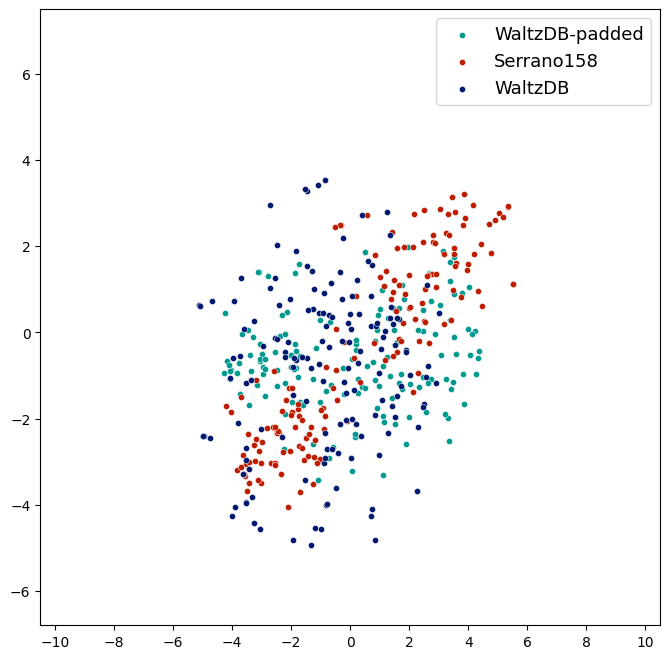

In [201]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_new[:,0], y=X_new[:,1], s=20, label='WaltzDB-padded', c=lacroix.colorList('Apricot')[3])
sns.scatterplot(x=X_new_serr[:,0], y=X_new_serr[:,1], s=20, label='Serrano158', c=lacroix.colorList('Apricot')[0])
sns.scatterplot(x=X_new_wp[:,0], y=X_new_wp[:,1], s=20, label='WaltzDB', c=lacroix.colorList('Apricot')[2])
plt.legend(fontsize=13)
plt.xticks(range(-12,12,2))
plt.xlim([-10.5,10.5])

plt.yticks(range(-8,10,2))
plt.ylim([-6.8,7.5])

plt.show()
#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')